In [1]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.0/929.0 kB 3.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
 #example of ARCH model 
import numpy as np 
from random import gauss 
from random import seed 
from matplotlib import pyplot 
from arch import arch_model 
import pandas as pd 
from scipy.stats import binom

In [4]:
data = pd.read_csv("/Users/dsdcba1/Downloads/dollar-yen-exchange-rate-historical-chart.csv", header = 8)

In [6]:
data.head()

,date,value
0,1971-01-04,357.73
1,1971-01-05,357.81
2,1971-01-06,357.86
3,1971-01-07,357.87
4,1971-01-08,357.82


In [8]:
data.tail()

,date,value
13653,2023-11-15,151.2765
13654,2023-11-16,150.7175
13655,2023-11-17,149.5350
13656,2023-11-18,149.5350
13657,2023-11-20,148.3450


In [9]:
#Preprocessing

df=data[(data['date'] >= '2009-10-31') & (data['date'] <= '2023-11-20')] 

In [13]:
df.rename(columns={'value':'value'}, inplace=True)
df['return']=df.value.pct_change()
return_list=df['return'].tolist()[1:]

/var/folders/3s/jzblmwmd6bb1z6zxqjy91l8w0000gn/T/ipykernel_4438/2160877115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'value':'value'}, inplace=True)
/var/folders/3s/jzblmwmd6bb1z6zxqjy91l8w0000gn/T/ipykernel_4438/2160877115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return']=df.value.pct_change()


In [17]:
# Using GARCH(1,1) to determine the volatility 
model=arch_model(return_list, mean='Zero', vol='GARCH', p=1, q=1) 
model_fit = model.fit() 
volatility = model_fit.conditional_volatility
print(model_fit.summary())

Iteration:      1,   Func. Count:      4,   Neg. LLF: -15117.361724297236
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -15117.36173712577
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                15117.4
Distribution:                  Normal   AIC:                          -30228.7
Method:            Maximum Likelihood   BIC:                          -30209.9
                                        No. Observations:                 3914
Date:                Wed, Feb 14 2024   Df Residuals:                     3914
Time:                        22:20:35   Df Model:                            0
         

/Users/dsdcba1/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.055e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/dsdcba1/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [18]:
# Estimate the volatility in the next date
omega = model_fit.params['omega']
alpha = model_fit.params['alpha[1]'] 
beta = model_fit.params['beta[1]'] 
vola_estimate = omega + alpha * np.power(return_list[-1] , 2) + beta * np.power( volatility[-1] , 2 ) 
vola_estimate = np.sqrt(vola_estimate) 
print('The volatility in the next date=', vola_estimate ) 
#return_scienarios = [] #for i in range(0,return_list)

The volatility in the next date= 0.0050511420949833795


In [19]:
#Value at Risk Calculation: historical simulation with volatility updating

In [20]:
# calculate the predicted value in the next date under different scenario and inporporate volatility updating 

In [26]:
Market_scienarios = []
N_history = len(return_list)
Value_current = df.loc[df.index[-1], 'value'] 
df.loc[df.index[-1], 'value']
for i in range(0, N_history ): 
    Market_value = Value_current * ( 1 + return_list[i] * vola_estimate/volatility[i] ) 
    Market_scienarios.append(Market_value)



In [27]:
# Value at Risk (VaR) determination # CL_Var: condifence level for VaR
CL_VaR = 95 
Value_current = df.loc[df.index[-1], 'value']
Value_at_Risk = np.percentile(Market_scienarios,100-CL_VaR) - Value_current 
print("The 1 day", CL_VaR,"% VaR:", -Value_at_Risk)

The 1 day 95 % VaR: 1.1522058803844288


In [31]:
# Make the histogram of loss for the scenaros considered between current date and the next date
import matplotlib.pyplot as plt

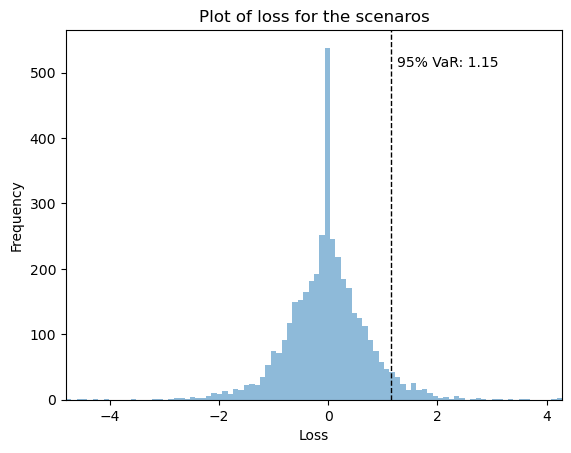

In [37]:
mss = np.asarray(Value_current - Market_scienarios )
plt.xlim([min(mss), max(mss)]) 
plt.hist(mss, bins='auto', alpha=0.5)
plt.title('Plot of loss for the scenaros')
plt.xlabel('Loss') 
plt.ylabel('Frequency') 
plt.axvline( -Value_at_Risk , color='k', linestyle='dashed', linewidth=1) 
min_ylim, max_ylim = plt.ylim()
plt.text(-Value_at_Risk*1.1, max_ylim*0.9, '{}% VaR: {:.2f}'.format(CL_VaR ,-Value_at_Risk)) 
plt.show()

In [38]:
# Confidence level for backtesting
# The probability of the VaR beeing exceeded on given day 

In [42]:
CL_backtesting = 95
p = 1 - CL_VaR/100
N_confidence = binom.ppf( CL_backtesting*0.01, N_history, p)
N_exceeded = sum( v < Value_at_Risk + Value_current for v in Market_scienarios)

In [44]:
print("We look at total", N_history,"days. VaR level is reached at", N_exceeded , "days.")
if N_exceeded <= N_confidence:
    print ("This VaR model is accepted at", CL_backtesting,"% confidence level.")
else: print ("This VaR model is rejected at", CL_backtesting,"% confidence level.")
    

We look at total 3914 days. VaR level is reached at 196 days.
This VaR model is accepted at 95 % confidence level.
